In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import random
from tqdm import trange
from scipy.stats import pointbiserialr
import math

warnings.filterwarnings('ignore')

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW-NB15/train.csv')
display(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW-NB15/test.csv')
display(test_raw.shape)

# Seperate label and Drop ID
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
test_Y = test_raw['label']

# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

(82332, 45)

(175341, 45)

In [3]:
# correlation based feature selection
corr = train_X1.corr().abs()

threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > threshold:
            redundant.append((i, j))

train_X2 = train_X1.copy()
train_X2['label'] = train_Y
corr2 = train_X2.corr().abs()

corr3 = corr2['label'].iloc[:-1].copy()
drop = []

#! modify
for i, j in redundant:
    if corr3[i] > corr3[j]:
        if j not in drop:
            drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

train_X1 = train_X1.drop(drop, axis=1)
test_X1 = test_X1.drop(drop, axis=1)
print(train_X1.shape)
print(test_X1.shape)

['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'tcprtt', 'ackdat', 'ct_dst_ltm', 'ct_srv_src', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
(82332, 24)
(175341, 24)


In [4]:
from sklearn.feature_selection import SelectKBest, RFECV, SequentialFeatureSelector, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
# greedy search
greedy_all = []
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
model = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
for k in trange(train_X1.shape[1]-1):
    features = []
    scores = []
    selector = SelectKBest(mutual_info_classif, k='all')
    # select one best feature and add it to subset
    selector.fit(train_X1.drop(greedy_all, axis=1), train_Y)
    f = train_X1.columns.drop(greedy_all)[np.argsort(selector.scores_)[0]]
    features.append(f)
    cv = cross_val_score(model, train_X1.drop(greedy_all+[f], axis=1), train_Y, scoring='f1', n_jobs=-1)
    scores.append(cv.mean())

    selector = SequentialFeatureSelector(clf, n_features_to_select=1, direction='backward', scoring='f1', cv=5, n_jobs=-1)
    # select one best feature and add it to subset
    selector.fit(train_X1.drop(greedy_all, axis=1), train_Y)
    f = train_X1.columns.drop(greedy_all)[selector.get_support()][0]
    features.append(f)
    cv = cross_val_score(model, train_X1.drop(greedy_all+[f], axis=1), train_Y, scoring='f1', n_jobs=-1)
    scores.append(cv.mean())

    selector = RFECV(clf, scoring='f1', cv=5, n_jobs=-1)
    selector.fit(train_X1, train_Y)
    f = train_X1.columns.drop(greedy_all)[np.argsort(selector.ranking_)[0]]
    features.append(f)
    cv = cross_val_score(model, train_X1.drop(greedy_all+[f], axis=1), train_Y, scoring='f1', n_jobs=-1)
    scores.append(cv.mean())

    clf.fit(train_X1.drop(greedy_all, axis=1), train_Y)
    f = train_X1.columns.drop(greedy_all)[np.argsort(clf.feature_importances_)[0]]
    features.append(f)
    cv = cross_val_score(model, train_X1.drop(greedy_all+[f], axis=1), train_Y, scoring='f1', n_jobs=-1)
    scores.append(cv.mean())

    i_best = np.argmax(scores)
    greedy_all.append(features[i_best])
greedy_all.append(train_X1.columns.drop(greedy_all)[0])
print(greedy_all)

100%|██████████| 23/23 [3:13:20<00:00, 504.39s/it]  

['dur', 'spkts', 'dpkts', 'trans_depth', 'smean', 'rate', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'sttl', 'response_body_len', 'dtcpb', 'stcpb', 'dmean', 'dload', 'sload', 'swin', 'ct_state_ttl', 'djit', 'sjit', 'dinpkt', 'synack', 'dttl', 'ct_dst_sport_ltm']


In [10]:
greedy_all = ['dur', 'spkts', 'dpkts', 'trans_depth',
       'smean', 'rate', 'ct_ftp_cmd',
       'ct_flw_http_mthd', 'sttl', 'response_body_len',
       'dtcpb', 'stcpb', 'dmean', 'dload',
       'sload', 'swin', 'ct_state_ttl', 'djit',
       'sjit', 'dinpkt', 'synack', 'dttl',
       'ct_dst_sport_ltm', 'sinpkt']
print(greedy_all)

['dur', 'spkts', 'dpkts', 'trans_depth', 'smean', 'rate', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'sttl', 'response_body_len', 'dtcpb', 'stcpb', 'dmean', 'dload', 'sload', 'swin', 'ct_state_ttl', 'djit', 'sjit', 'dinpkt', 'synack', 'dttl', 'ct_dst_sport_ltm', 'sinpkt']


In [11]:
# test with LR
cv_times_all = []
f1_all = []
model = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
for k in trange(train_X1.shape[1]):
    # cross validation
    second = time.time()
    cv = cross_val_score(model, train_X1[greedy_all[k:]], train_Y, scoring='f1', n_jobs=-1)
    second2 = time.time()
    cv_times_all.append(second2 - second)
    f1_all.append((cv.mean(), cv.std()))

100%|██████████| 24/24 [00:32<00:00,  1.34s/it]


In [ ]:
pd.DataFrame([cv_times_all[::-1]], index=['greedy'], columns=['']).to_csv('../Results/Paper/Greedy_Time_LR.csv')
pd.DataFrame([f1_all[::-1]], index=['greedy'], columns=['mean', 'std']).to_csv('../Results/Paper/Greedy_F1_LR.csv')

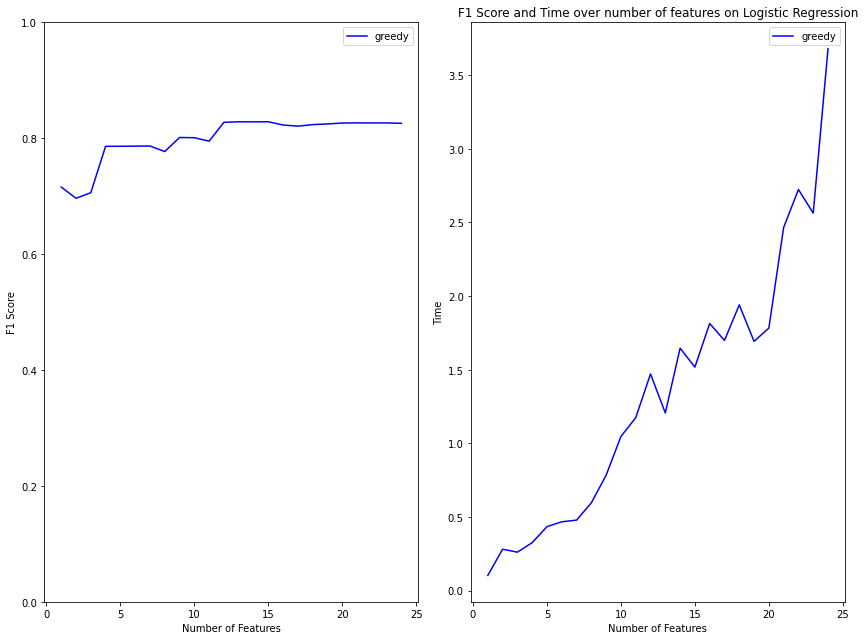

In [47]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Logistic Regression', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1], 0, -1), np.array(f1_all)[:,0], color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1], 0, -1), cv_times_all, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.show()

In [48]:
# test with GB
cv_times_all = []
f1_all = []
model = GradientBoostingClassifier(random_state=0)
for k in trange(train_X1.shape[1]):
    # cross validation
    second = time.time()
    cv = cross_val_score(model, train_X1[greedy_all[k:]], train_Y, scoring='f1', n_jobs=-1)
    second2 = time.time()
    cv_times_all.append(second2 - second)
    f1_all.append((cv.mean(), cv.std()))

100%|██████████| 24/24 [03:58<00:00,  9.93s/it]


In [49]:
pd.DataFrame([cv_times_all[::-1]], index=['greedy']).to_csv('../Results/Paper/Greedy_Time_GB.csv')
pd.DataFrame([f1_all[::-1]], index=['greedy']).to_csv('../Results/Paper/Greedy_F1_GB.csv')

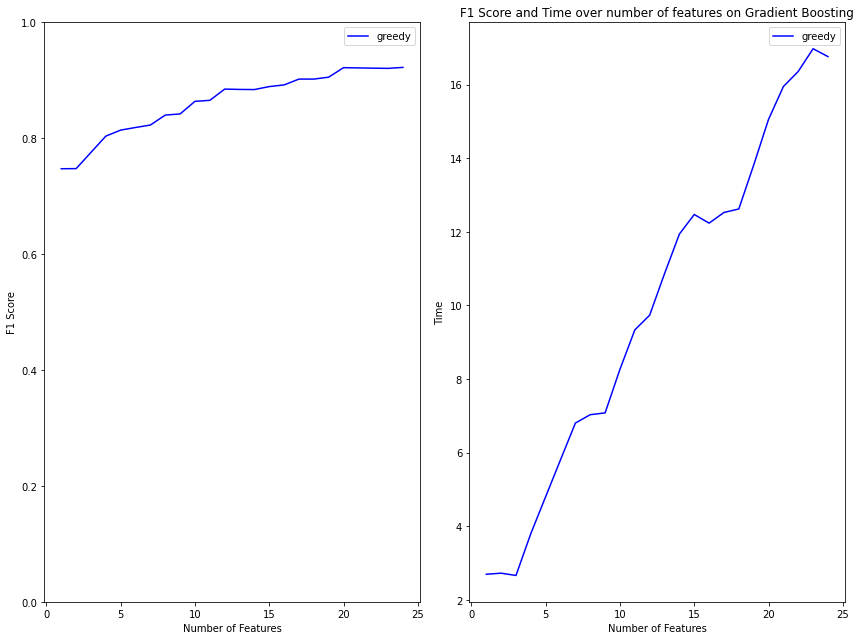

In [50]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Gradient Boosting', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1], 0, -1), np.array(f1_all)[:,0], color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1], 0, -1), cv_times_all, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.show()

In [51]:
from tensorflow.python.keras import Sequential, layers, losses, metrics, callbacks, backend
from sklearn.model_selection import StratifiedKFold

In [52]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [53]:
cv_times_all = []
f1_all = []
kf = StratifiedKFold(shuffle=True, random_state=0)
callback = callbacks.EarlyStopping(patience=3, min_delta=0.1, restore_best_weights=True)
for k in trange(train_X1.shape[1]):
    model = ModelCreate((train_X1.shape[1]-k,))
    # cross validation
    j = 0
    cv_time = 0
    cv = np.zeros(shape=5)
    train_X2 = train_X1[greedy_all[k:]].copy()
    for train_index, test_index in kf.split(train_X2, train_Y):
        x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
        y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

        second = time.time()
        model.fit(x_train_fold.values, y_train_fold.values, validation_data=(x_test_fold, y_test_fold), epochs=30, callbacks=[callback], verbose=0)
        predict = model.predict(x_test_fold, use_multiprocessing=True)
        predict = np.where(predict < 0.5, 0, 1)
        cv[j] = f1_score(y_test_fold, predict)
        second2 = time.time()
        cv_time += second2 - second
        j += 1
    backend.clear_session()
    cv_times_all.append(cv_time)
    f1_all.append((cv.mean(), cv.std()))

100%|██████████| 24/24 [1:11:24<00:00, 178.54s/it]


In [54]:
pd.DataFrame([cv_times_all[::-1]], index=['greedy']).to_csv('../Results/Paper/Greedy_Time_DNN.csv')
pd.DataFrame([f1_all[::-1]], index=['greedy']).to_csv('../Results/Paper/Greedy_F1_DNN.csv')

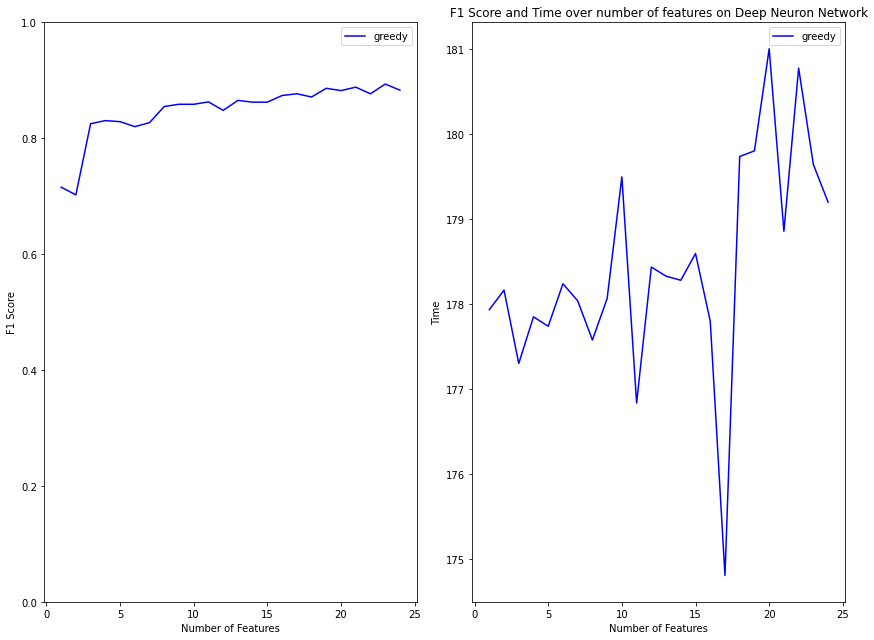

In [55]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Deep Neuron Network', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1], 0, -1), np.array(f1_all)[:,0], color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1], 0, -1), cv_times_all, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.show()